RF to predict tti or log tti or ahd from all other data
 use households until find pop
dimensionality reduction?

factorsd impacting congestion, networks, tti, modeshares

tti website has other papers
modeshare variables
feature importance what is the direction of impact (negative vs. positive, impurity)
plot to show errors from rf optimization, 2d contour plot
rf/gbm as feature extractor
pca, condense and explain
kernel pca
update manuscript
final model (generalize additive model)
poster

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

sns.set(style='whitegrid', context='poster', font_scale=1, palette='Set2')
# set pandas column display to none
pd.set_option('display.max_columns', None)


In [8]:
trf = pd.read_csv('../../data/tidy/tti-traffic19-renamed.csv')
net = pd.read_csv('../../data/tidy/data-aggregation-networkstats.csv')
inc = pd.read_csv('../../data/tidy/acs19-hh-income.csv')
mod = pd.read_csv('../../data/tidy/acs19-modeshares.csv')
unemp = pd.read_csv('../../data/tidy/acs19-unemp.csv')
pop = pd.read_csv('../../data/tidy/acs19-pop.csv')

In [9]:
df = trf.merge(net, on='msa', how='left')
df = df.merge(mod, left_on='msa', right_on='msa', how='inner')
df = df.merge(unemp, left_on = 'msa', right_on = 'msa', how = 'left')
df = df.merge(inc, left_on = 'msa', right_on = 'msa', how = 'left')
df = df.merge(pop, left_on = 'msa', right_on = 'msa', how = 'left')
df = df.dropna(subset=['tti'])
# df = df.set_index('msa')
# df['log_tti'] = np.log10(df['tti'])


In [10]:
from pathlib import Path  
filepath = Path('../../data/tidy/congestion-exploration19_MM.csv', index = False)  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath)

--------------------------
## Jimi:
- Comulative feature importance for feature selection based on Random Forests (select the top features), then:
- PCA then PCR
- PCA then GAM
- PCA to RF
- KPCA

--------------------------  
# Perform ...

In [11]:
data = df.copy()
# Set 'msa' column as index
data = data.set_index('msa')
data.head()

,auto_commuters,annual_excess_fuel_consumed_commuters,ahd_ph,tti,n,m,k_avg,edge_length_total,edge_length_avg,streets_per_node_avg,intersection_count,street_length_total,street_segment_count,street_length_avg,circuity_avg,self_loop_proportion,node_density_km,intersection_density_km,edge_density_km,street_density_km,builing_area_sqkm,area_sqkm,ms_cara_per,ms_carp_per,ms_pt_per,ms_taxi_per,ms_bike_per,ms_walk_per,ms_wfh_per,unemp,med_hh_inc_dol,households,population
msa,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Abilene, TX",64,1282,2548,1.07,14357,39401,5.488751,1.716897e+07,435.749497,2.881452,11912,8.925436e+06,20606,433.147439,1.067840,0.004465,2.012523,1.669790,2406.696840,1251.142264,7.048505,7133.829924,80.291133,100.105752,0.510579,0.915432,0.265604,1.943037,5.499039,3.4,52511,60931,170669
"Akron, OH",298,6741,15835,1.10,26865,70900,5.278243,1.519199e+07,214.273426,2.756896,21200,8.039295e+06,36980,217.395754,1.056240,0.015089,11.231303,8.862967,6351.230011,3360.943838,14.307097,2391.975398,84.673598,100.071737,1.303214,0.614118,0.096859,1.592914,4.545640,5.4,57285,286543,703845
"Albany, GA",54,870,1905,1.08,8466,22838,5.395228,9.545102e+06,417.948256,2.837468,6957,4.989593e+06,11954,417.399446,1.052833,0.002928,2.028965,1.667318,2287.583389,1195.808038,6.979580,4172.570196,81.190732,100.114382,0.995359,0.906248,0.131145,1.585513,3.752774,10.6,44844,55714,148436
"Albany-Lebanon, OR",35,465,1046,1.06,7132,17906,5.021312,8.280294e+06,462.431276,2.568144,5101,4.225439e+06,9147,461.948061,1.150205,0.005466,1.193324,0.853498,1385.456359,706.999160,7.519705,5976.582645,79.296969,100.111969,0.170747,1.503313,0.645868,2.225274,4.960932,6.6,55893,47762,125048
"Albany-Schenectady-Troy, NY",297,6240,15617,1.15,36977,96867,5.239311,2.787244e+07,287.739291,2.755794,30254,1.455542e+07,50900,285.961192,1.091565,0.033320,4.962653,4.060365,3740.737967,1953.471821,41.455466,7451.054339,79.338492,100.080156,3.618297,0.859834,0.280518,3.332137,4.555087,4.6,71285,352713,880736


calculating the cumulative feature importance using a Random Forest model.

In [35]:
from sklearn.ensemble import RandomForestRegressor

# Define the features and target
X = data.drop(columns=['tti']) # drop the target and the ahd_ph
# drop ahd_ph
X = X.drop(columns=['ahd_ph'])
# drop annual_excess_fuel
X = X.drop(columns=['annual_excess_fuel_consumed_commuters'])
# drop auto
# X = X.drop(columns=['auto_commuters'])
y = data['tti']

# Create a Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42,)

# Train the model
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": importances})

# Sort by importance
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

importances_df  = feature_importances.copy()

# plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))
sns.barplot(x="Importance", y="Feature", data=feature_importances)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()


KeyError: "['tti'] not found in axis"

- 'ahd_ph', 'annual_excess_fuel_consumed_commuters', and 'auto_commuters' are the most important features in predicting 'tti'.

## Decide on a cutoff for feature importance
- We might choose to only consider features that contribute at least 1% of the total importance. (This gived 10 features)
- Or, we might select the features that contribute a sum of 95%  (gives 18 features)

C:\Users\Mohammed\AppData\Local\Temp\ipykernel_42108\4219598067.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(feature_importances.Feature, rotation=90)


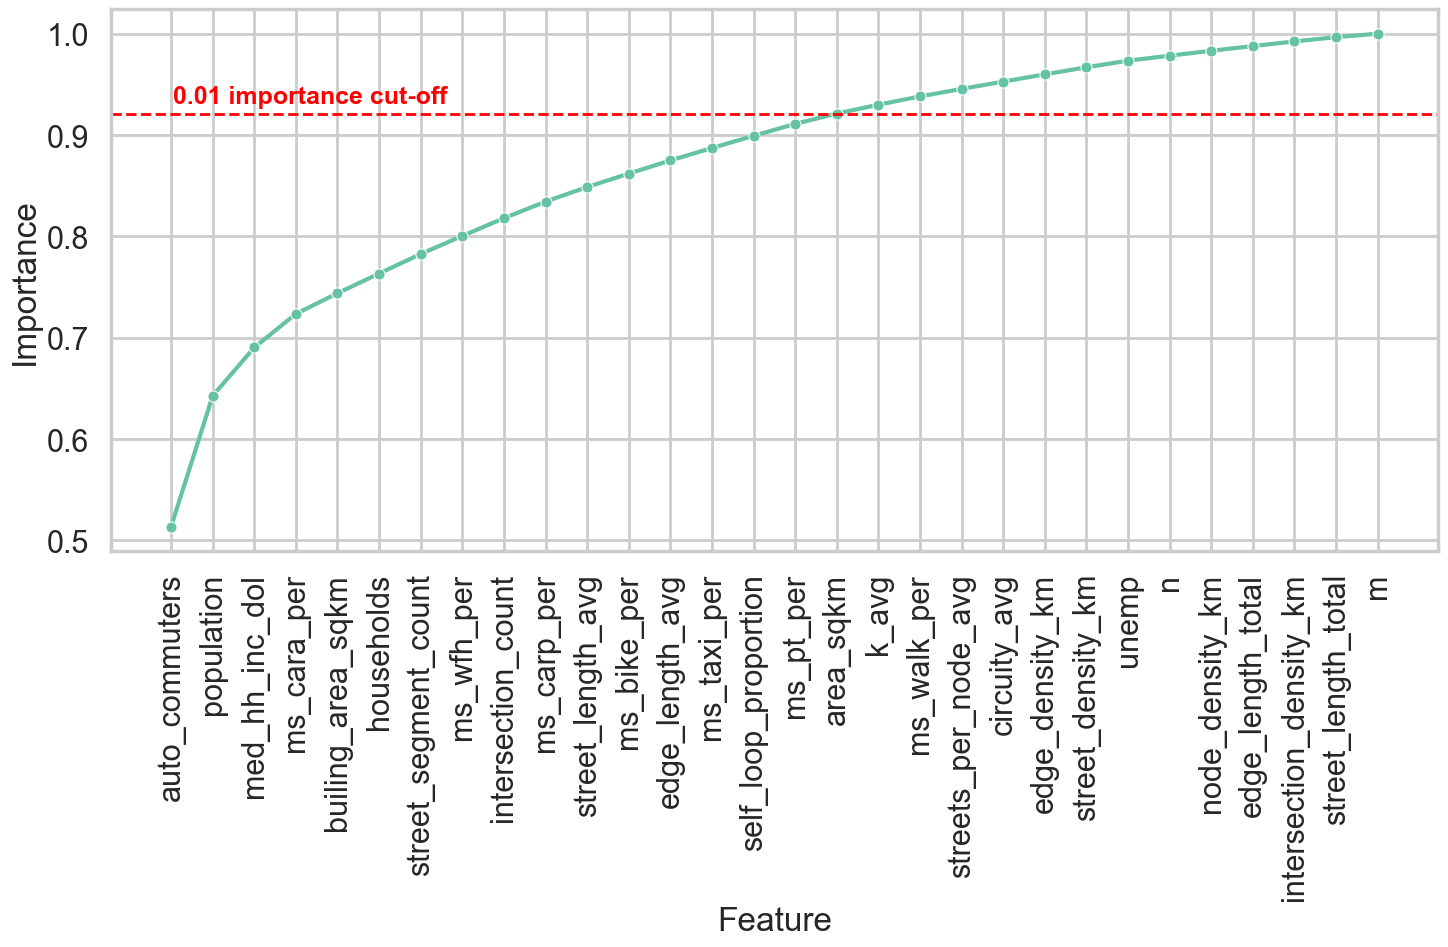

In [31]:
# find features with importance > 0.01
important_features = []
for i in range(len(importances)): 
    if importances[i] > 0.009: 
        important_features.append(i)
num_important_features = len(important_features)



# sort by importance and make a new column with cumulative importance from biggest to smallest
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importances['cumulative_importance'] = np.cumsum(feature_importances['Importance'])
feature_importances


# make line plot with cumulative sum of feature importance from feature_importances and cut off at 95% of total importance
fig, ax = plt.subplots(figsize=(15, 10))
sns.lineplot(x="Feature", y="cumulative_importance", ax=ax, data=feature_importances, 
             marker='o', 
            #  label='Cumulative Sum of Feature Importance', 
             sort=False,
                linewidth=3, #color='blue',
                # markerfacecolor='blue', 
                markersize=8,
                # markeredgewidth=1, 
                # markeredgecolor='blue'
                )
# ax.set_title('Cumulative Sum of Feature Importance')
ax.set_xlabel('Feature')
ax.set_ylabel('Importance')
ax.set_xticklabels(feature_importances.Feature, rotation=90)
# ax.set_xticks(np.arange(len(feature_importances_cumsum.index)))
# ax.set_xlim(0, 10)
# ax.set_ylim(0, 1.1)
# make a line at the first feature the the difference between its importance and the next feature is less than 0.01 and make the line at the y value of this feature
# caculate the sum of the top features
top_sum = feature_importances.iloc[:num_important_features]['Importance'].sum()
ax.axhline(top_sum, ls='--', color='red', linewidth=2, label='95% cut-off threshold')
# add text with the cumulative importance value at the end of the line
ax.text(0.051, top_sum+0.01, '0.01 importance cut-off ', fontsize=18, color='red', #bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2'), 
zorder=10, weight='bold')

plt.tight_layout()
plt.show()

17 features required for 92.11% of total importance


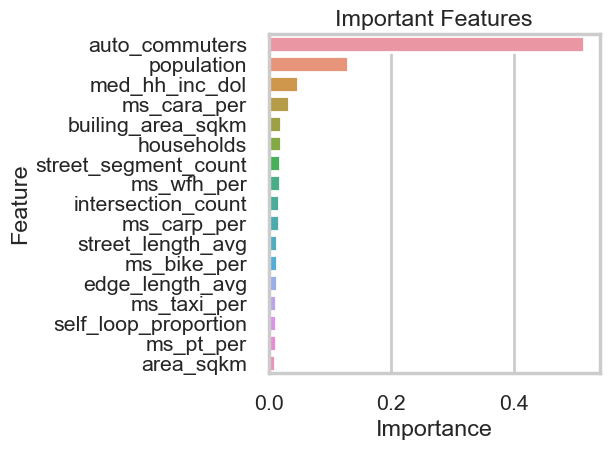

In [198]:
# Select the important features from the dataset that are the top 17
# features that contribute to 95% of the total importance
important_features = feature_importances.nlargest(num_important_features, "Importance")

# Number of important features
num_important_features = important_features.shape[0]

important_features, 


# print num_important_features
print(f"{num_important_features} features required for {100 * np.sum(important_features['Importance']):.2f}% of total importance")

# plot the important features using seaborn and make it horizontal
sns.barplot(x = "Importance", y = "Feature", data = important_features.sort_values(by = "Importance", ascending = False))
plt.title("Important Features")
plt.tight_layout()
# title
plt.title("Important Features")
plt.show()


- split the dataset into a training set and a test set.
    - 70% training set and a 30% test set

In [199]:
from sklearn.model_selection import train_test_split

# Select the important features
X_imp = X[important_features['Feature']]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape


((251, 17), (108, 17))

-------------------------------
# 1. KPCA followed BY PCR (Principal Component Regression)
- KPCA will transform our features into a set of components that are nonlinearly uncorrelated through the use of a kernel function. We cant estimate how much variance is explained by each PC, so we can't choose the number of components to keep based on the amount of variance explained. 
- KPCR (Kernel Principal Component Regression) will then use these transformed components to fit a linear regression model.

In [200]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
# Standardize the features (necessary for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Perform Grid search on the KPCA model and select the best parameters based on the R2 score of the KPCR model

In [201]:
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


# There is no gam in the pipline so just use linear regression instead of gam as below and use the best parameters with a gam KPCR later.

# Pipeline: KernelPCA + Linear Regression
pipeline = Pipeline([
    ('kpca', KernelPCA(fit_inverse_transform=True, n_jobs=-1, random_state=42, copy_X=True, alpha=1.0, eigen_solver='auto', tol=0, max_iter=None, remove_zero_eig=False)),
    ('linreg', LinearRegression(n_jobs=-1))
])

# Parameter grid to search
param_grid = {
    'kpca__kernel': ['rbf', 'poly', 'sigmoid'],
    'kpca__n_components': [5, 10, 15,30, 50, 100],
    'kpca__gamma': [0.01, 0.05, 0.1],
    'kpca__degree': [2, 3, 4],
    'kpca__coef0': [0, 1, 2]
}

# Grid Search with Cross Validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train_scaled, y_train)





c:\Users\mazee\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 2430.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\mazee\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\mazee\miniconda3\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\mazee\miniconda3\lib\site-packages\sklearn\pipeline.py", line 416, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\mazee\minico

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('kpca',
                                        KernelPCA(fit_inverse_transform=True,
                                                  n_jobs=-1, random_state=42)),
                                       ('linreg',
                                        LinearRegression(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'kpca__coef0': [0, 1, 2], 'kpca__degree': [2, 3, 4],
                         'kpca__gamma': [0.01, 0.05, 0.1],
                         'kpca__kernel': ['rbf', 'poly', 'sigmoid'],
                         'kpca__n_components': [5, 10, 15, 30, 50, 100]},
             return_train_score=True, scoring='r2')

In [202]:
# Optimal parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'kpca__coef0': 2, 'kpca__degree': 2, 'kpca__gamma': 0.01, 'kpca__kernel': 'sigmoid', 'kpca__n_components': 15}


In [177]:
# Convert results to DataFrame
# cv_results = pd.DataFrame(grid_search.cv_results_)

# # Subplots for each parameter
# fig, axes = plt.subplots(2, 2, figsize=[15, 12])

# for ax, param in zip(axes.flat, ['kpca__kernel', 'kpca__gamma', 'kpca__degree', 'kpca__coef0']):
#     for value in param_grid[param]:
#         subset = cv_results[cv_results[param] == value]
#         ax.plot(subset['rank_test_score'], subset['mean_test_score'], label=f"{param} = {value}")
#     ax.set_xlabel('Rank')
#     ax.set_ylabel('R2 Value')
#     ax.set_title(f'R2 Value vs Rank for {param}')
#     ax.legend()

# plt.tight_layout()
# plt.show()


### First KPCA, then analyze and select the first 10 PCs that explain at least 90% of the variance, then apply PCR to the PCs

#### Select the variance threshold here
- with 90% variance explained, we need 8 PCs and gave us R2 of 0.3
- with 95% variance explained, we need 11 PCs and gave us R2 of 0.4
- with 99% variance explained, we need 16 PCs and gave us R2 of 0.8
- with 100% variance explained, we need 19 PCs and gave us R2 of 0.75 ## So it is not worth it to use 100% variance explained

Number of components explaining 0.9999% variance:  14


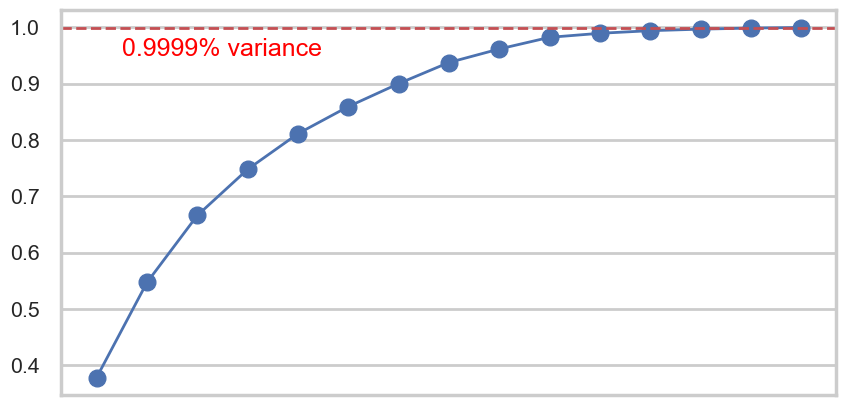

In [229]:
from sklearn.decomposition import KernelPCA

# Perform Kernel PCA # Using Radial basis function (RBF) kernel which is also known as the Gaussian kernel
kpca = KernelPCA(kernel="sigmoid", fit_inverse_transform=True,  n_components=15, n_jobs=-1, random_state=42, 
                 copy_X=True, gamma=0.01, degree=2, coef0=2, alpha=1.0, eigen_solver='arpack', tol=0, 
                 max_iter=None, remove_zero_eig=False, )
X_train_kpca = kpca.fit_transform(X_train_scaled)
X_test_kpca = kpca.transform(X_test_scaled)


percentage_var_explained = 0.9999
kpca.eigenvalues_
plt.figure(figsize=(10,5))
cpve2 = np.cumsum(kpca.eigenvalues_)/np.sum(kpca.eigenvalues_)
# plot the eigenvalues
plt.plot(cpve2, 'bo-', linewidth=2)
# add a line at 90% variance
plt.axhline(y=percentage_var_explained, color='r', linestyle='--', linewidth=2, markersize=12, label=f'{percentage_var_explained}% variance')
# add text under the red line
plt.text(0.5, percentage_var_explained-0.05, f'{percentage_var_explained}% variance', color = 'red', fontsize=18)
# add tick labels every 2 ticks
plt.xticks(range(0, n_components, 2))

# get the number of components that explain % variance
n_components = np.argmax(cpve2 >= percentage_var_explained) 
print(f"Number of components explaining {percentage_var_explained}% variance: ", n_components)


# keep only these components
X_train_kpca = X_train_kpca[:, :n_components]
X_test_kpca = X_test_kpca[:, :n_components]

#### Try linear regression KPCR

In [236]:
# # Fit the PCR Model on the data transformed by KPCA
# kpcr = LinearRegression( fit_intercept=True,  copy_X=True, n_jobs=-1,  positive=False,)
# kpcr.fit(X_train_kpca, y_train)

# # Predictions
# train_preds_kpca = kpcr.predict(X_train_kpca)
# test_preds_kpca = kpcr.predict(X_test_kpca)

# # Evaluation
# mape_train_kpca = mean_absolute_percentage_error(y_train, train_preds_kpca)
# mape_test_kpca = mean_absolute_percentage_error(y_test, test_preds_kpca)

# rmse_train_kpca = np.sqrt(mean_squared_error(y_train, train_preds_kpca))
# rmse_test_kpca = np.sqrt(mean_squared_error(y_test, test_preds_kpca))

# r2_train_kpca = r2_score(y_train, train_preds_kpca)
# r2_test_kpca = r2_score(y_test, test_preds_kpca)

# mape_train_kpca, mape_test_kpca, rmse_train_kpca, rmse_test_kpca, r2_train_kpca, r2_test_kpca

# # print
# print(f"MAPE Train: {mape_train_kpca}\nMAPE Test: {mape_test_kpca}\nRMSE Train: {rmse_train_kpca}\nRMSE Test: {rmse_test_kpca}\nR2 Train: {r2_train_kpca}\nR2 Test: {r2_test_kpca}")
# 

#### Try GAM with KPCR

In [237]:
from pygam import LinearGAM

# Fit the GAM Model on the data transformed by KPCA
kpcr = LinearGAM(n_splines=10, lam=0.001, 
                fit_intercept=True, 
                ).gridsearch(X_train_kpca, y_train)


# Predictions
train_preds_kpca = kpcr.predict(X_train_kpca)
test_preds_kpca = kpcr.predict(X_test_kpca)

# Evaluation
mape_train_kpca = mean_absolute_percentage_error(y_train, train_preds_kpca)
mape_test_kpca = mean_absolute_percentage_error(y_test, test_preds_kpca)

rmse_train_kpca = np.sqrt(mean_squared_error(y_train, train_preds_kpca))
rmse_test_kpca = np.sqrt(mean_squared_error(y_test, test_preds_kpca))

r2_train_kpca = r2_score(y_train, train_preds_kpca)
r2_test_kpca = r2_score(y_test, test_preds_kpca)

mape_train_kpca, mape_test_kpca, rmse_train_kpca, rmse_test_kpca, r2_train_kpca, r2_test_kpca

# print
print(f"MAPE Train: {mape_train_kpca}\nMAPE Test: {mape_test_kpca}\nRMSE Train: {rmse_train_kpca}\nRMSE Test: {rmse_test_kpca}\nR2 Train: {r2_train_kpca}\nR2 Test: {r2_test_kpca}")


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:02
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:02
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:02
 36% (4 of 11) |#########                | Elapsed Time: 0:00:01 ETA:   0:00:02
 45% (5 of 11) |###########              | Elapsed Time: 0:00:01 ETA:   0:00:01
 54% (6 of 11) |#############            | Elapsed Time: 0:00:01 ETA:   0:00:01
 63% (7 of 11) |###############          | Elapsed Time: 0:00:02 ETA:   0:00:01
 72% (8 of 11) |##################       | Elapsed Time: 0:00:02 ETA:   0:00:01
 81% (9 of 11) |####################     | Elapsed Time: 0:00:02 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:03 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


MAPE Train: 0.024248455755139547
MAPE Test: 0.0245122312750224
RMSE Train: 0.035107396982521424
RMSE Test: 0.03601068783098245
R2 Train: 0.745138199145557
R2 Test: 0.8110110708295198


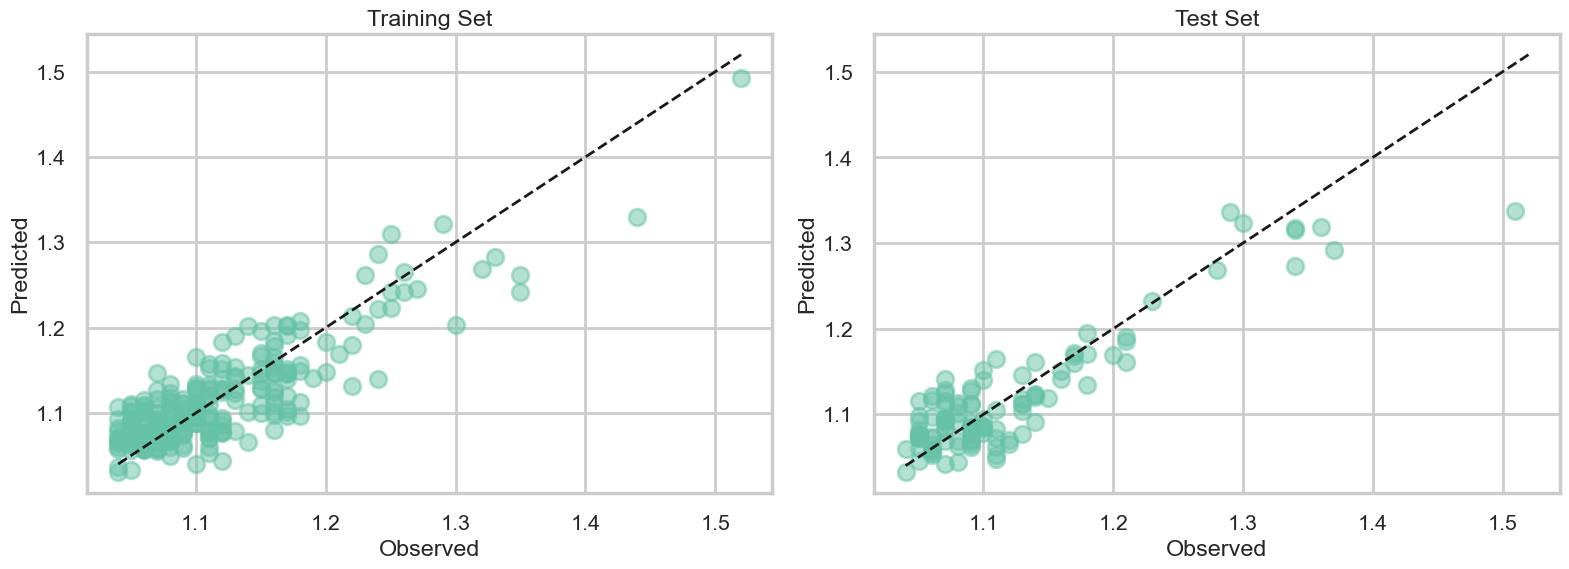

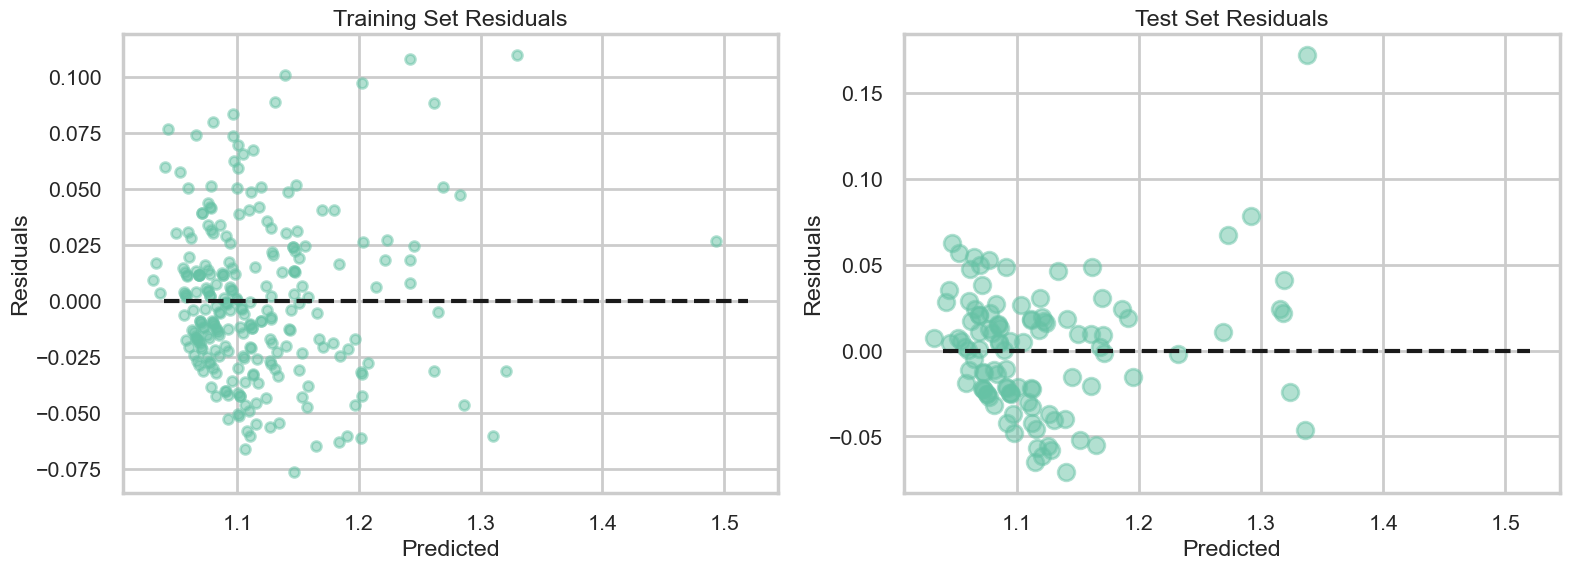

In [240]:
# Plot observed vs predicted values
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Training set
axs[0].scatter(y_train, train_preds_kpca, alpha=0.5)
axs[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
axs[0].set_xlabel('Observed')
axs[0].set_ylabel('Predicted')
axs[0].set_title('Training Set')

# Test set
axs[1].scatter(y_test, test_preds_kpca, alpha=0.5)
axs[1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
axs[1].set_xlabel('Observed')
axs[1].set_ylabel('Predicted')
axs[1].set_title('Test Set')

plt.tight_layout()
plt.show()

# Calculate residuals
train_residuals_kpca = y_train - train_preds_kpca
test_residuals_kpca = y_test - test_preds_kpca

# Plot residuals
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Training set
axs[0].scatter(train_preds_kpca, train_residuals_kpca, alpha=0.5, s=50)
axs[0].hlines(y=0, xmin=y.min(), xmax=y.max(), colors='k', linestyles='dashed')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Residuals')
axs[0].set_title('Training Set Residuals')

# Test set
axs[1].scatter(test_preds_kpca, test_residuals_kpca, alpha=0.5)
axs[1].hlines(y=0, xmin=y.min(), xmax=y.max(), colors='k', linestyles='dashed')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Residuals')
axs[1].set_title('Test Set Residuals')

plt.tight_layout()
plt.show()


## KPCR coefficients 

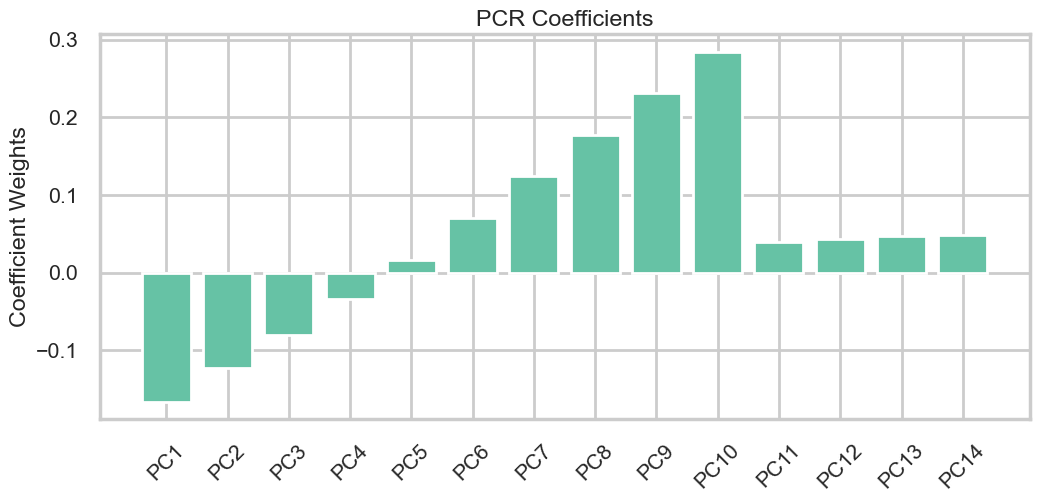

In [233]:
# plot the coefficients of the pcr for the first 10 components
plt.figure(figsize=(12, 5))
plt.bar(np.arange(1, n_components+1), kpcr.coef_[:n_components].T)
plt.ylabel('Coefficient Weights')
plt.title('PCR Coefficients')
# add PC labels to x-axis  so the ygo pc1, pc2, pc3, etc.
plt.xticks(np.arange(1, n_components+1), ['PC'+str(i) for i in range(1, n_components+1)], rotation=45)
plt.show()


###  Change the number in for i in range(30) and unit_vector = np.zeros((1, 30)) to the number of n_components in kpca model

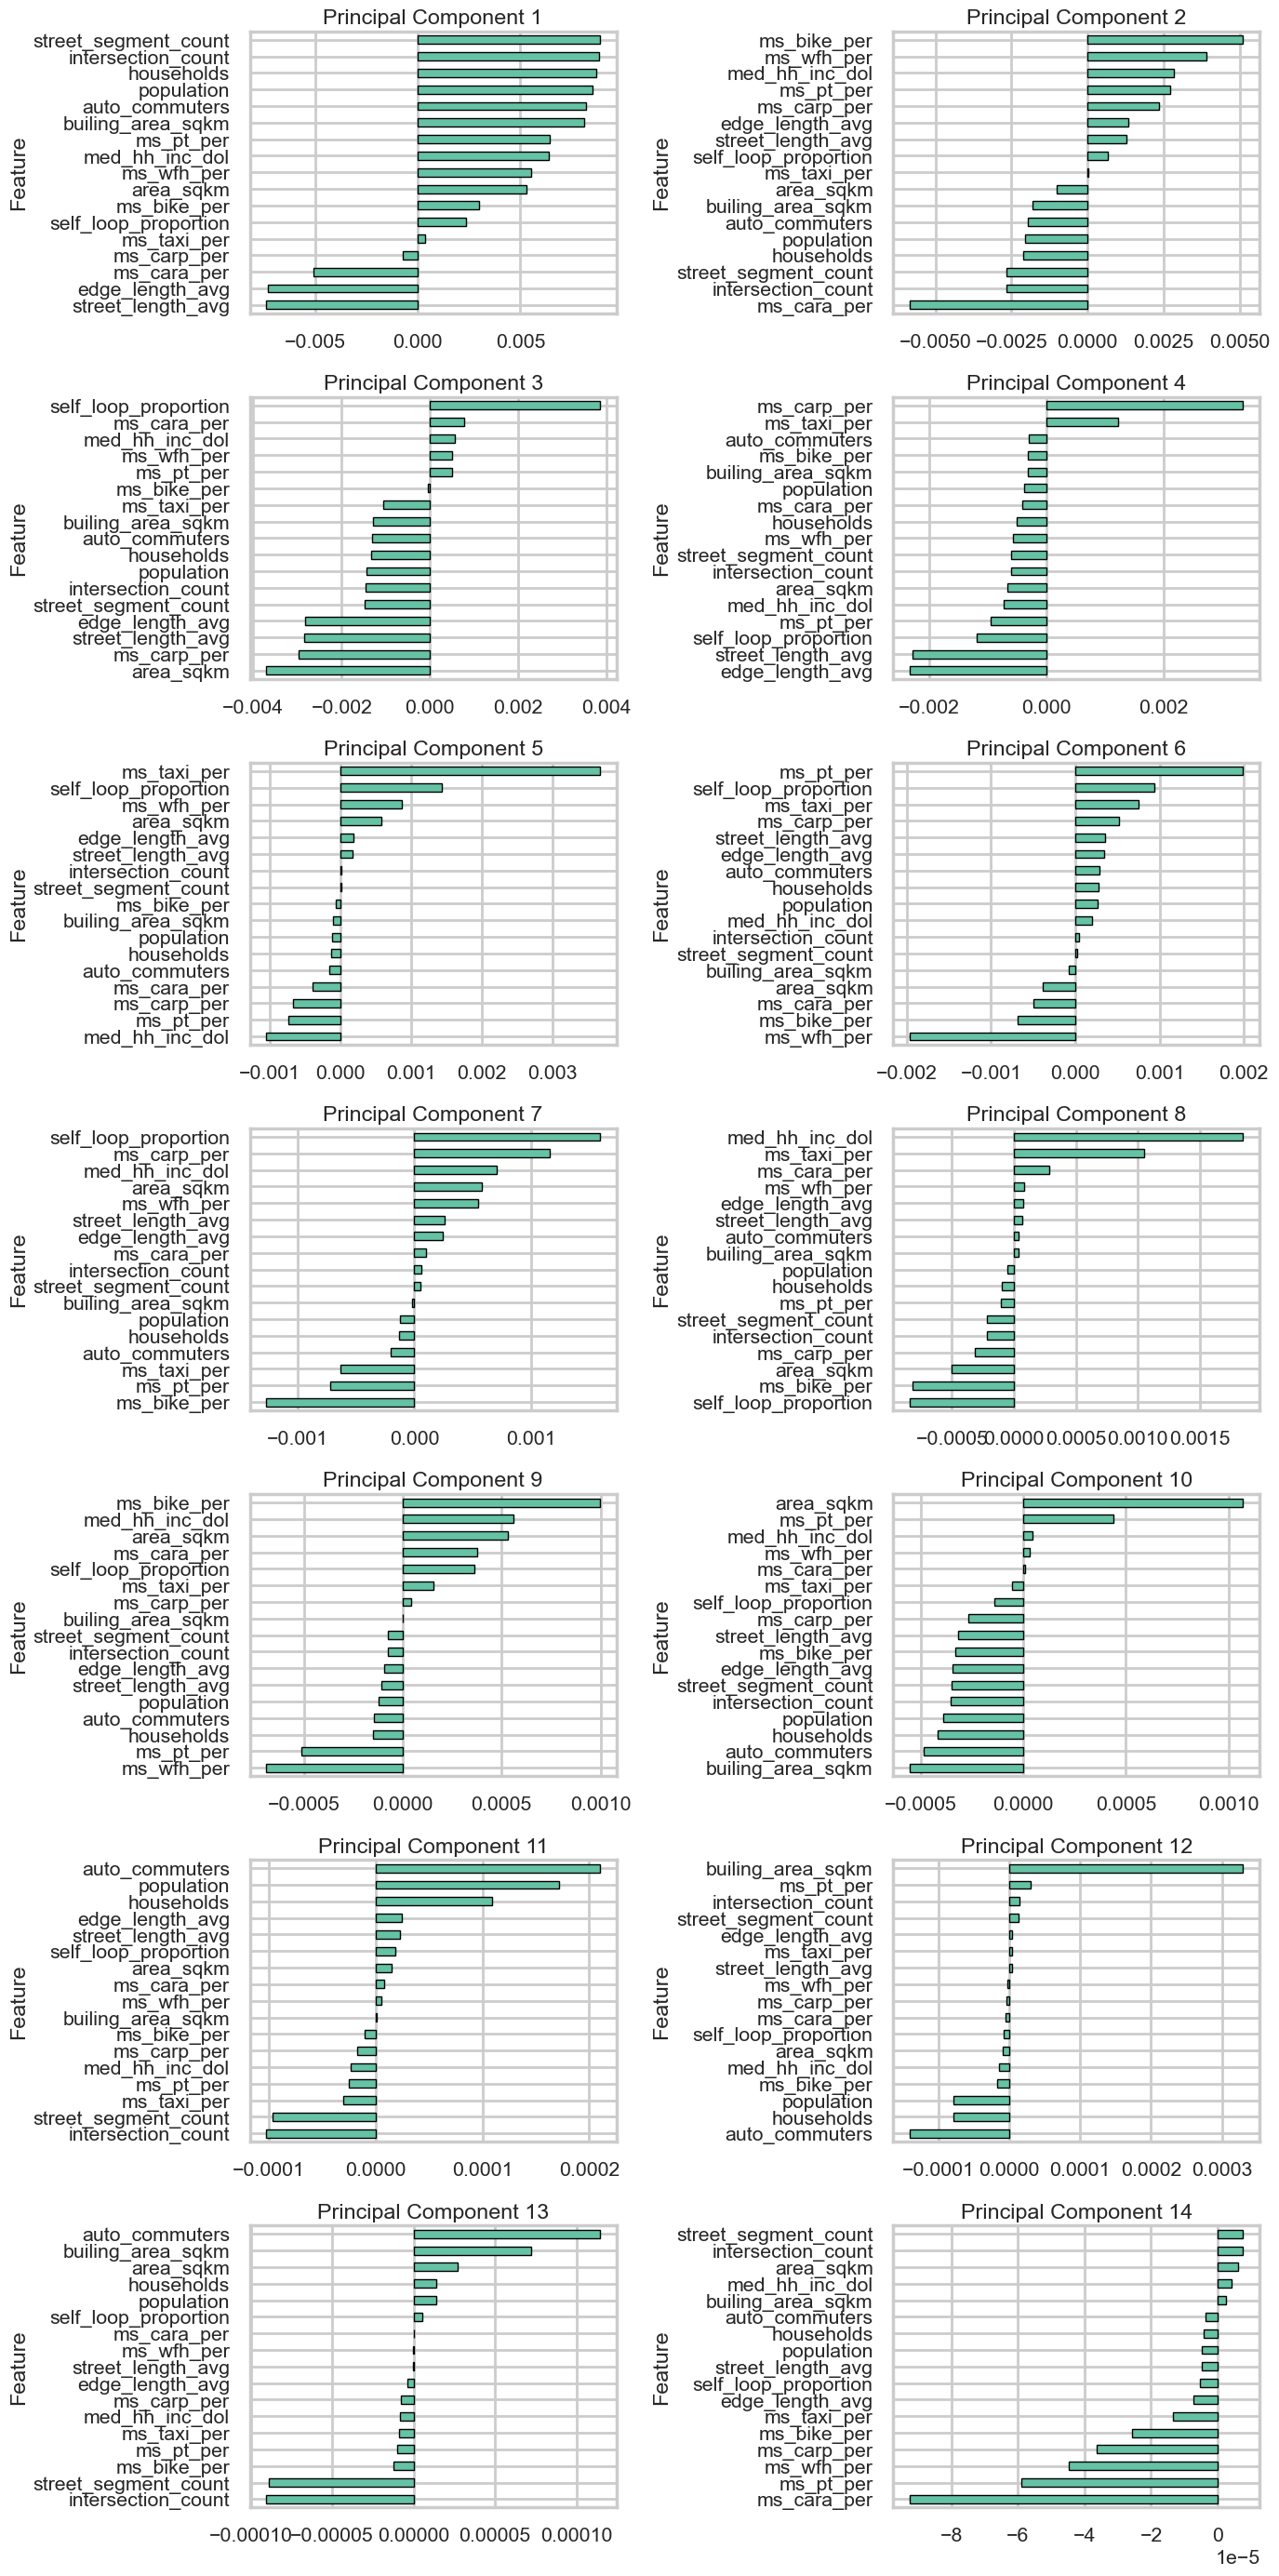

In [235]:
# Initialize an empty DataFrame to hold the contributions
contributions = pd.DataFrame()

# Iterate over each principal component
for i in range(15): 

    # Create a unit vector along the i-th principal component axis
    unit_vector = np.zeros((1, 15))
    unit_vector[0, i] = 1

    # Inverse transform the unit vector to the original feature space
    unit_vector_inverse = kpca.inverse_transform(unit_vector)

    # Create a DataFrame with the contributions of each original feature
    contributions_i = pd.DataFrame(data=unit_vector_inverse, columns=X_train.columns)

    # Add the contributions to the main DataFrame
    contributions = pd.concat([contributions, contributions_i], ignore_index=True)

# Plot the contributions in subpolts  showing only the first 6 and add the feature names as y axis labels sice the bars will be horizontal
fig, axes = plt.subplots(nrows=(n_components//2), ncols=2, figsize=(n_components, n_components*2))
for i, ax in enumerate(axes.ravel()):
    contributions.iloc[i].sort_values().plot(kind='barh', ax=ax, edgecolor='black', linewidth=1)
    # use sns

    ax.set_title('Principal Component {}'.format(i+1))
    ax.set_ylabel('Feature')
plt.tight_layout()
plt.show()


## For plotting the loadings of single PC
### Select the PC to plot in pc_value

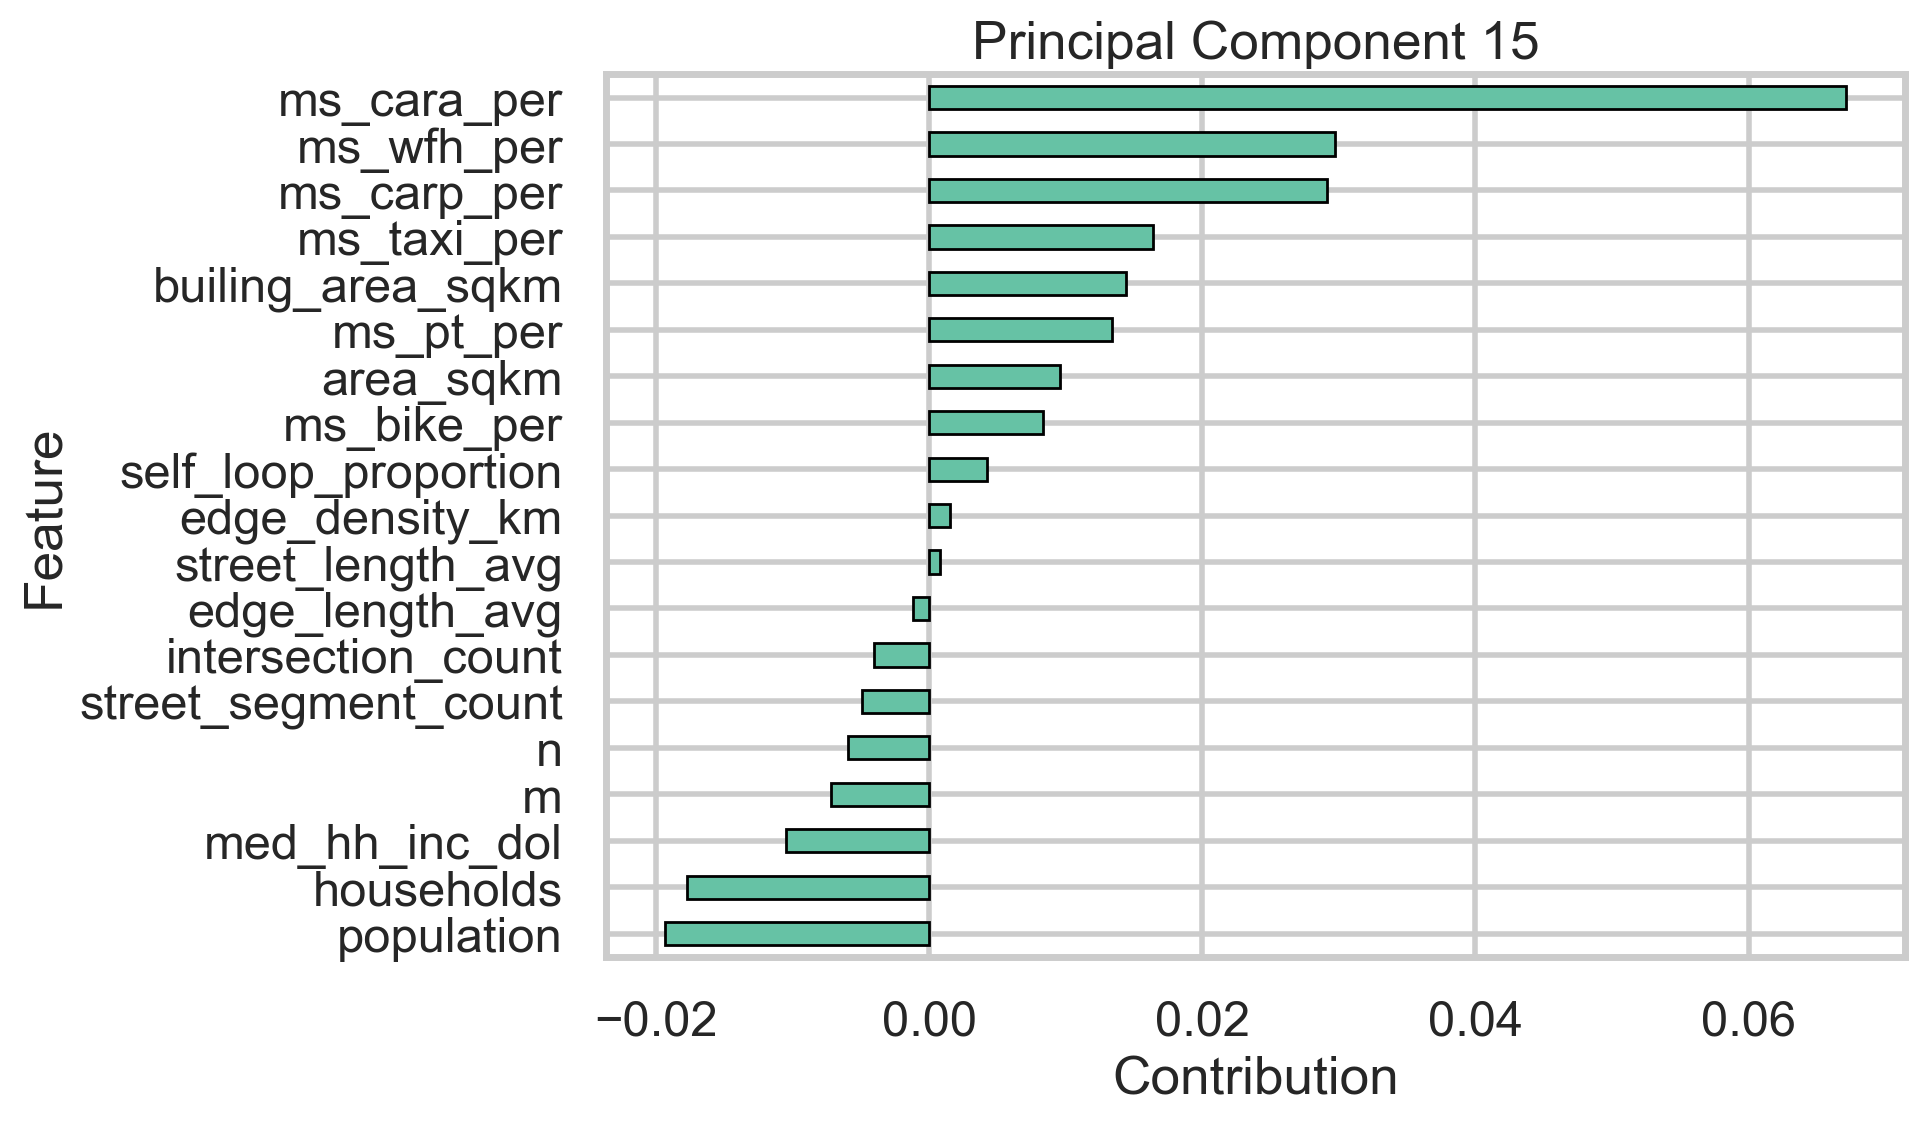

In [164]:

# only plot pc ##
pc_value = 15
sns.set(style='whitegrid', context='poster', font_scale=0.8, palette='Set2')
fig, ax = plt.subplots(figsize=(10, 6), dpi=200, facecolor='w', edgecolor='k', )
contributions.iloc[pc_value - 1].sort_values().plot(kind='barh', edgecolor='black', linewidth=1)
plt.title(f'Principal Component {pc_value}')
plt.xlabel('Contribution')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


